In [13]:
#from cld_data_processing import download_data

In [2]:
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.data import Dataset

from typing import NamedTuple, Tuple

In [4]:
class Params(NamedTuple):
    """
    Job Parameters
    """
    image_size: int
    batch_size: int
    epochs: int
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool

In [5]:
tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, True, 5, False)
DEFAULT_PARAMS

In [20]:
# IMAGE_SIZE = 255
# BATCH_SIZE = 196

# EPOCHS = 50
# ES = True
# ES_PATIENCE = 10

`/data/data_processing.py`

In [11]:
def create_ds_tree(x, y, path, name) -> Path:
    """
    
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, params: Params) -> Dataset:
    """
    """
    img_size = params.image_size
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=params.batch_size,
    )   
    
    
def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def data_preprocessing(path: Path, params: Params, force=False) -> Tuple[Dataset, Dataset, Dataset]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params)
    ds_valid = create_dataset(valid_path, params)
    ds_test = create_dataset(test_path, params)

    return ds_train, ds_valid, ds_test

In [ ]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

`/model/utils.py`

In [14]:
def use_pre_trained_model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [15]:
def run_experiment_lr(exp_id: str, sub_exp_id: int, model_fn: str, ds_train_: Dataset, ds_valid_: Dataset, params: Params):
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [16]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

`main.py`

In [ ]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test = data_preprocessing(Path(cwd), DEFAULT_PARAMS)

In [12]:
df_results = pd.DataFrame

In [13]:
# ES = True
# LR = False
# IMAGE_SIZE = 255
# BATCH_SIZE = 196

# ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 2)
(m, df_hist) = run_experiment_lr("pre_trained_model_convnext_tiny", 1, use_pre_trained_model_convnext_tiny, ds_train, ds_valid)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1710845803.236233     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710845803.272104     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845803.272518     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845803.272914     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845803.273287     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845803.273677     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845803.274018     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845803.274357     115 graph_launch.cc:671] Fallback to op-by-op mode because m

65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5357 - loss: 1.3135

W0000 00:00:1710845846.975961     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845846.976459     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845846.977052     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5367 - loss: 1.3109

W0000 00:00:1710845852.406932     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.407254     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.407751     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.408127     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.408517     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.408877     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.409268     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710845852.409666     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5376 - loss: 1.3083 - val_accuracy: 0.6633 - val_loss: 0.8673
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 703ms/step - accuracy: 0.6540 - loss: 0.9199 - val_accuracy: 0.6991 - val_loss: 0.7866
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 709ms/step - accuracy: 0.6830 - loss: 0.8426 - val_accuracy: 0.7103 - val_loss: 0.7558
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 703ms/step - accuracy: 0.7057 - loss: 0.7978 - val_accuracy: 0.7147 - val_loss: 0.7378
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 710ms/step - accuracy: 0.7085 - loss: 0.7833 - val_accuracy: 0.7241 - val_loss: 0.7208
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 703ms/step - accuracy: 0.7169 - loss: 0.7580 - val_accuracy: 0.7336 - val_loss: 0.7064
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 705ms/step - accuracy: 0.7245 - loss: 0.7428 - val_accuracy: 0.7334 - val_loss: 0.7039
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 47s 703ms/step - accuracy: 0.7327 - loss: 0.7257 - val_accuracy: 0.7430 

In [14]:
m.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.7759 - loss: 0.6197


[0.5999157428741455, 0.7857476472854614]

In [30]:
def augment_dataset(ds: Dataset, num_repeats: int):
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

In [16]:
ds_train_aug = augment_dataset(ds_train, 2)

In [17]:
(m2, df_hist) = run_experiment_lr("pre_trained_model_convnext_tiny", 1, use_pre_trained_model_convnext_tiny, ds_train_aug, ds_valid)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

Using EarlyStopping
Epoch 1/50


W0000 00:00:1710847861.052359     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.052833     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.053215     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.053573     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.053958     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.054313     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.054706     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847861.055079     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/132 ━━━━━━━━━━━━━━━━━━━━ 42s 640ms/step - accuracy: 0.5535 - loss: 1.2615

W0000 00:00:1710847908.913683     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847908.914105     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847908.914582     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.5875 - loss: 1.1629

W0000 00:00:1710847955.700853     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.701194     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.701510     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.701850     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.702161     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.702491     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.702832     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710847955.703176     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 126s 822ms/step - accuracy: 0.5879 - loss: 1.1618 - val_accuracy: 0.6967 - val_loss: 0.7971
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 602ms/step - accuracy: 0.6800 - loss: 0.8499 - val_accuracy: 0.7131 - val_loss: 0.7490
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 603ms/step - accuracy: 0.7061 - loss: 0.7910 - val_accuracy: 0.7304 - val_loss: 0.7167
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 602ms/step - accuracy: 0.7169 - loss: 0.7542 - val_accuracy: 0.7386 - val_loss: 0.6975
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7283 - loss: 0.7240 - val_accuracy: 0.7453 - val_loss: 0.6809
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7383 - loss: 0.6982 - val_accuracy: 0.7484 - val_loss: 0.6683
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.7484 - loss: 0.6788 - val_accuracy: 0.7516 - val_loss: 0.6552
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 602ms/step - accuracy: 0.7583 - loss: 0.6578 - va

In [20]:
m2.evaluate(ds_test)
[0.5999157428741455, 0.7857476472854614]

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 514ms/step - accuracy: 0.7889 - loss: 0.5856


[0.5910516381263733, 0.788084089756012]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

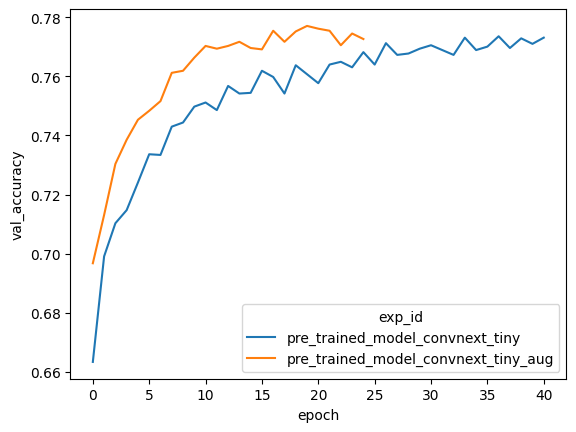

In [16]:
plot_experiments_comp(df_results,["pre_trained_model_convnext_tiny", "pre_trained_model_convnext_tiny_aug", "pretrained_baseline_avg_no_bn_train_full_big3"], "val_accuracy")

In [31]:
ds_train_aug_lg = augment_dataset(ds_train, 4)

In [ ]:
ES = True
LR = False
IMAGE_SIZE = 255
BATCH_SIZE = 196

# ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 2)
(m3, df_hist) = run_experiment_lr("pre_trained_model_convnext_tiny_aug4", 1, use_pre_trained_model_convnext_tiny, ds_train_aug_lg, ds_valid)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

Using EarlyStopping
Epoch 1/50


I0000 00:00:1710852100.452033     323 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710852100.489728     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852100.490186     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852100.490589     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852100.490992     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852100.491429     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852100.491799     323 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852100.492193     323 graph_launch.cc:671] Fallback to op-by-op mode because m

 65/264 ━━━━━━━━━━━━━━━━━━━━ 2:05 631ms/step - accuracy: 0.5545 - loss: 1.2836

W0000 00:00:1710852152.319557     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852152.319930     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710852152.320481     320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/264 ━━━━━━━━━━━━━━━━━━━━ 1:06 705ms/step - accuracy: 0.5964 - loss: 1.1449

In [28]:
df_results_x = df_results.copy()

In [29]:
df_results_x.reset_index()

,level_0,index,accuracy,loss,val_accuracy,val_loss,exp_id,sub_exp_id,epoch
0,0,0,0.599439,1.138423,0.663318,0.867270,pre_trained_model_convnext_tiny,1,0
1,1,1,0.659266,0.909969,0.699065,0.786586,pre_trained_model_convnext_tiny,1,1
2,2,2,0.682402,0.841656,0.710280,0.755838,pre_trained_model_convnext_tiny,1,2
3,3,3,0.698995,0.804101,0.714720,0.737811,pre_trained_model_convnext_tiny,1,3
4,4,4,0.705850,0.786195,0.724065,0.720783,pre_trained_model_convnext_tiny,1,4
...,...,...,...,...,...,...,...,...,...
61,20,20,0.828971,0.467336,0.776168,0.623261,pre_trained_model_convnext_tiny,1,20
62,21,21,0.835047,0.451998,0.775467,0.629046,pre_trained_model_convnext_tiny,1,21
63,22,22,0.837579,0.447000,0.770561,0.640892,pre_trained_model_convnext_tiny,1,22
64,23,23,0.846187,0.429894,0.774533,0.641994,pre_trained_model_convnext_tiny,1,23


In [30]:
df_results_x.to_csv("resultsx.csv")

In [32]:
df_results_x = df_results_x.reset_index()

In [36]:
df_results_x

,level_0,index,accuracy,loss,val_accuracy,val_loss,exp_id,sub_exp_id,epoch
0,0,0,0.599439,1.138423,0.663318,0.867270,pre_trained_model_convnext_tiny,1,0
1,1,1,0.659266,0.909969,0.699065,0.786586,pre_trained_model_convnext_tiny,1,1
2,2,2,0.682402,0.841656,0.710280,0.755838,pre_trained_model_convnext_tiny,1,2
3,3,3,0.698995,0.804101,0.714720,0.737811,pre_trained_model_convnext_tiny,1,3
4,4,4,0.705850,0.786195,0.724065,0.720783,pre_trained_model_convnext_tiny,1,4
...,...,...,...,...,...,...,...,...,...
61,20,20,0.828971,0.467336,0.776168,0.623261,pre_trained_model_convnext_tiny,1,20
62,21,21,0.835047,0.451998,0.775467,0.629046,pre_trained_model_convnext_tiny,1,21
63,22,22,0.837579,0.447000,0.770561,0.640892,pre_trained_model_convnext_tiny,1,22
64,23,23,0.846187,0.429894,0.774533,0.641994,pre_trained_model_convnext_tiny,1,23


In [18]:
#!rm -rf /kaggle/working/data

In [2]:
import pandas as pd

In [4]:
df_res = pd.read_csv("/kaggle/input/results-fixed/results_fixed.csv")

In [12]:
df_results = pd.read_csv("/kaggle/working/results.csv")

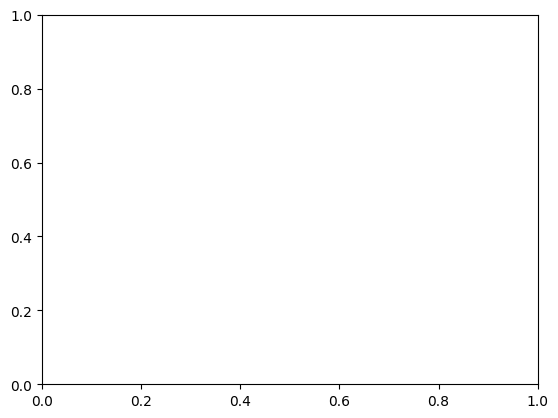

In [15]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext", "use_pre_trained_model_convnext_aug"], "val_accuracy")

In [5]:
df_res.to_csv("results.csv")